In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
import datetime
import joblib
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from random import randint
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from hyperopt import hp, tpe, fmin, Trials,STATUS_OK

### Data preprocessing

In [ ]:
def load_csv(filepath):
    
    df = pd.read_csv(filepath)

    return df

data_train = load_csv('pipeline/data/train.csv')
data_test = load_csv('pipeline/data/test.csv')

In [3]:
def oneHotCatVars(df, df_cols):
    
    df_1 = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

def preprocess(df_):
    
    df = df_.copy()
    #missing value
    df = df.drop(df[df.od_number_of_similar_2_hours < 0].index)
    
    trip_or_dest = [f"{start}{end}"
         for start, end in zip( df.origin_station_name, df.destination_station_name)]
    df['trip_or_dest'] = trip_or_dest
    #df = df.assign(trip_or_dest = lambda data: trip_or_dest)
    
    trip_id = [f"{datetime}{time}{start}{end}"
       for datetime, time, start, end in zip(df.departure_date, df.od_origin_time, df.origin_station_name, df.destination_station_name)]
    df['trip_id'] = trip_id
    #df = df.assign(trip_id=lambda data:trip_id)
    
    sale_week = [datetime.date(year, month, day).isocalendar()[1]
                 for year, month, day in zip(df.sale_year, df.sale_month, df.sale_day)
                ]
    df['sale_week'] = sale_week
    
    df['cum_demand'] = df.groupby(['trip_id'],sort=False).demand.cumsum()
    # Add new column: final_demand  =  as max(cum_bookings) for a given deparrture date  
    df['final_demand'] = df.groupby(['trip_id'], sort=False)['cum_demand'].transform(max) 
    # Add new colum: remaining_demand = final_demand - cum_bookings
    df['remaining_demand'] = df['final_demand'] - df['cum_demand']
    #Historical avg_booking_rates_demands for each day_prior (into) week_day combination     
    df['avg_remaining_demand'] = df.groupby(['sale_day_x'], sort=False)['remaining_demand'].transform(np.mean)  
    # Add new colum: booking_rate = cum_bookings / final_demand  
    df['booking_rate'] = df['cum_demand'] /df['final_demand']
    # Historical avg_booking_rates_demands for each day_prior (into) week_day combination     
    df['avg_booking_rate_weekday'] = df.groupby(['sale_day_x', 'sale_weekday'], sort=False)['booking_rate'].transform(np.mean)  
    # Historical avg_booking_rates_demands for each day_prior      
    df['avg_booking_rate'] = df.groupby(['sale_day_x'], sort=False)['booking_rate'].transform(np.mean)
    
    categorical_features_redondance = ['departure_date','sale_date','dataset_type','destination_station_name','origin_station_name']
    categorical_features_to_process = ['trip_or_dest']
    df = df.drop(columns=categorical_features_redondance)
    df = oneHotCatVars(df, categorical_features_to_process)
    
    
    df = df.join(
    df.groupby('trip_id')['price'].aggregate(['mean', 'min', 'max']),
    on='trip_id'
)

    
    # shift column 'Name' to first position
    first_column = df.pop('trip_id')
  
    # insert column using insert(position,column_name,
    # first_column) function
    df.insert(0, 'trip_id', first_column)
    
    # shift column 'Name' to first position
    second_column = df.pop('price')
  
    # insert column using insert(position,column_name,
    # first_column) function
    df.insert(1, 'price', second_column)
    return df

In [4]:
def preprocessing_data(data):
    
    preprocessing_data = preprocess(data_train)
    
    return preprocessing_data
    
data_train_clean = preprocessing_data(data_train)
data_test_clean = preprocessing_data(data_test)

### Model creation

### Bayesian optimization tunning

In [5]:
def split_data(df):
    
    
    X = df.drop(columns = ['demand','trip_id'])
    y= df['demand']
    
    
    
    return X,y

X_train,y_train = split_data(data_train_clean)
X_test, y_test = split_data(data_test_clean)


In [6]:
X_t = X_train[:10000]
y_t = y_train[:10000]

In [7]:
space={
    'subsample': hp.uniform('subsample',0.5, 1),
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators' : hp.choice('n_estimators',[100, 200, 500]),
   'learning_rate': hp.uniform("learning_rate", 0.001, 0.1)
        
        
    }



def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], learning_rate=space['learning_rate'], 
                         subsample = space['subsample'])
    
    evaluation = [( X_t, y_t), ( X_test, y_test)]
    
    model.fit(X_t, y_t,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:                                                 
15.432842370243486                                     
SCORE:                                                                           
13.788808893360406                                                               
SCORE:                                                                           
15.051608020985608                                                               
SCORE:                                                                           
14.467281122986897                                                               
SCORE:                                                                           
17.053045387441333                                                               
SCORE:                                                                           
14.679319216935893                                                               
SCORE:                                                              

14.26741215578115                                                                 
SCORE:                                                                            
13.438262879843808                                                                
100%|██████████| 100/100 [12:09<00:00,  7.29s/trial, best loss: 13.262730319567833]


In [8]:
best

{'colsample_bytree': 0.6776350054418449,
 'gamma': 5.355128396172938,
 'learning_rate': 0.018896273065147556,
 'max_depth': 11.0,
 'min_child_weight': 7.0,
 'n_estimators': 2,
 'reg_alpha': 40.0,
 'reg_lambda': 0.5855251693421832,
 'subsample': 0.7509606344529771}

In [16]:
xgb_model_bayes_optim = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.67,
        gamma = 5,
        learning_rate = 0.01,
        max_depth = 11,
        min_child_weight = 7,
        n_estimators = 500,
        reg_alpha = 40,
        reg_lambda = 0.58,
        subsample = 0.75)


### Training model 

In [17]:
def fit_model(X_t, y_t, model, early_stop):
    
    
    model.fit(X_t, y_t, early_stopping_rounds = early_stop, eval_set=[(X_t, y_t)],verbose=False)
    
    filename = 'XGBoost_demand.sav'
    joblib.dump(model, 'pipeline/models/'+filename)
    
    return model

Xgb_model_trained = fit_model(X_train, y_train,xgb_model_bayes_optim,5)

In [18]:
predict_train = Xgb_model_trained.predict(X_train)
predict_test = Xgb_model_trained.predict(X_test)

In [19]:
rmse = np.sqrt(MSE(y_test,predict_test))
print("RMSE_test : % f" %(rmse))
mae_xgb = mean_absolute_error(y_test, predict_test)
print("MAE_test: ", mae_xgb)

rmse = np.sqrt(MSE(y_train,predict_train))
print("RMSE_train : % f" %(rmse))
mae_xgb = mean_absolute_error(y_train, predict_train)
print("MAE_train: ", mae_xgb)

RMSE_test :  2.284444
MAE_test:  1.07372979816849
RMSE_train :  2.284444
MAE_train:  1.07372979816849


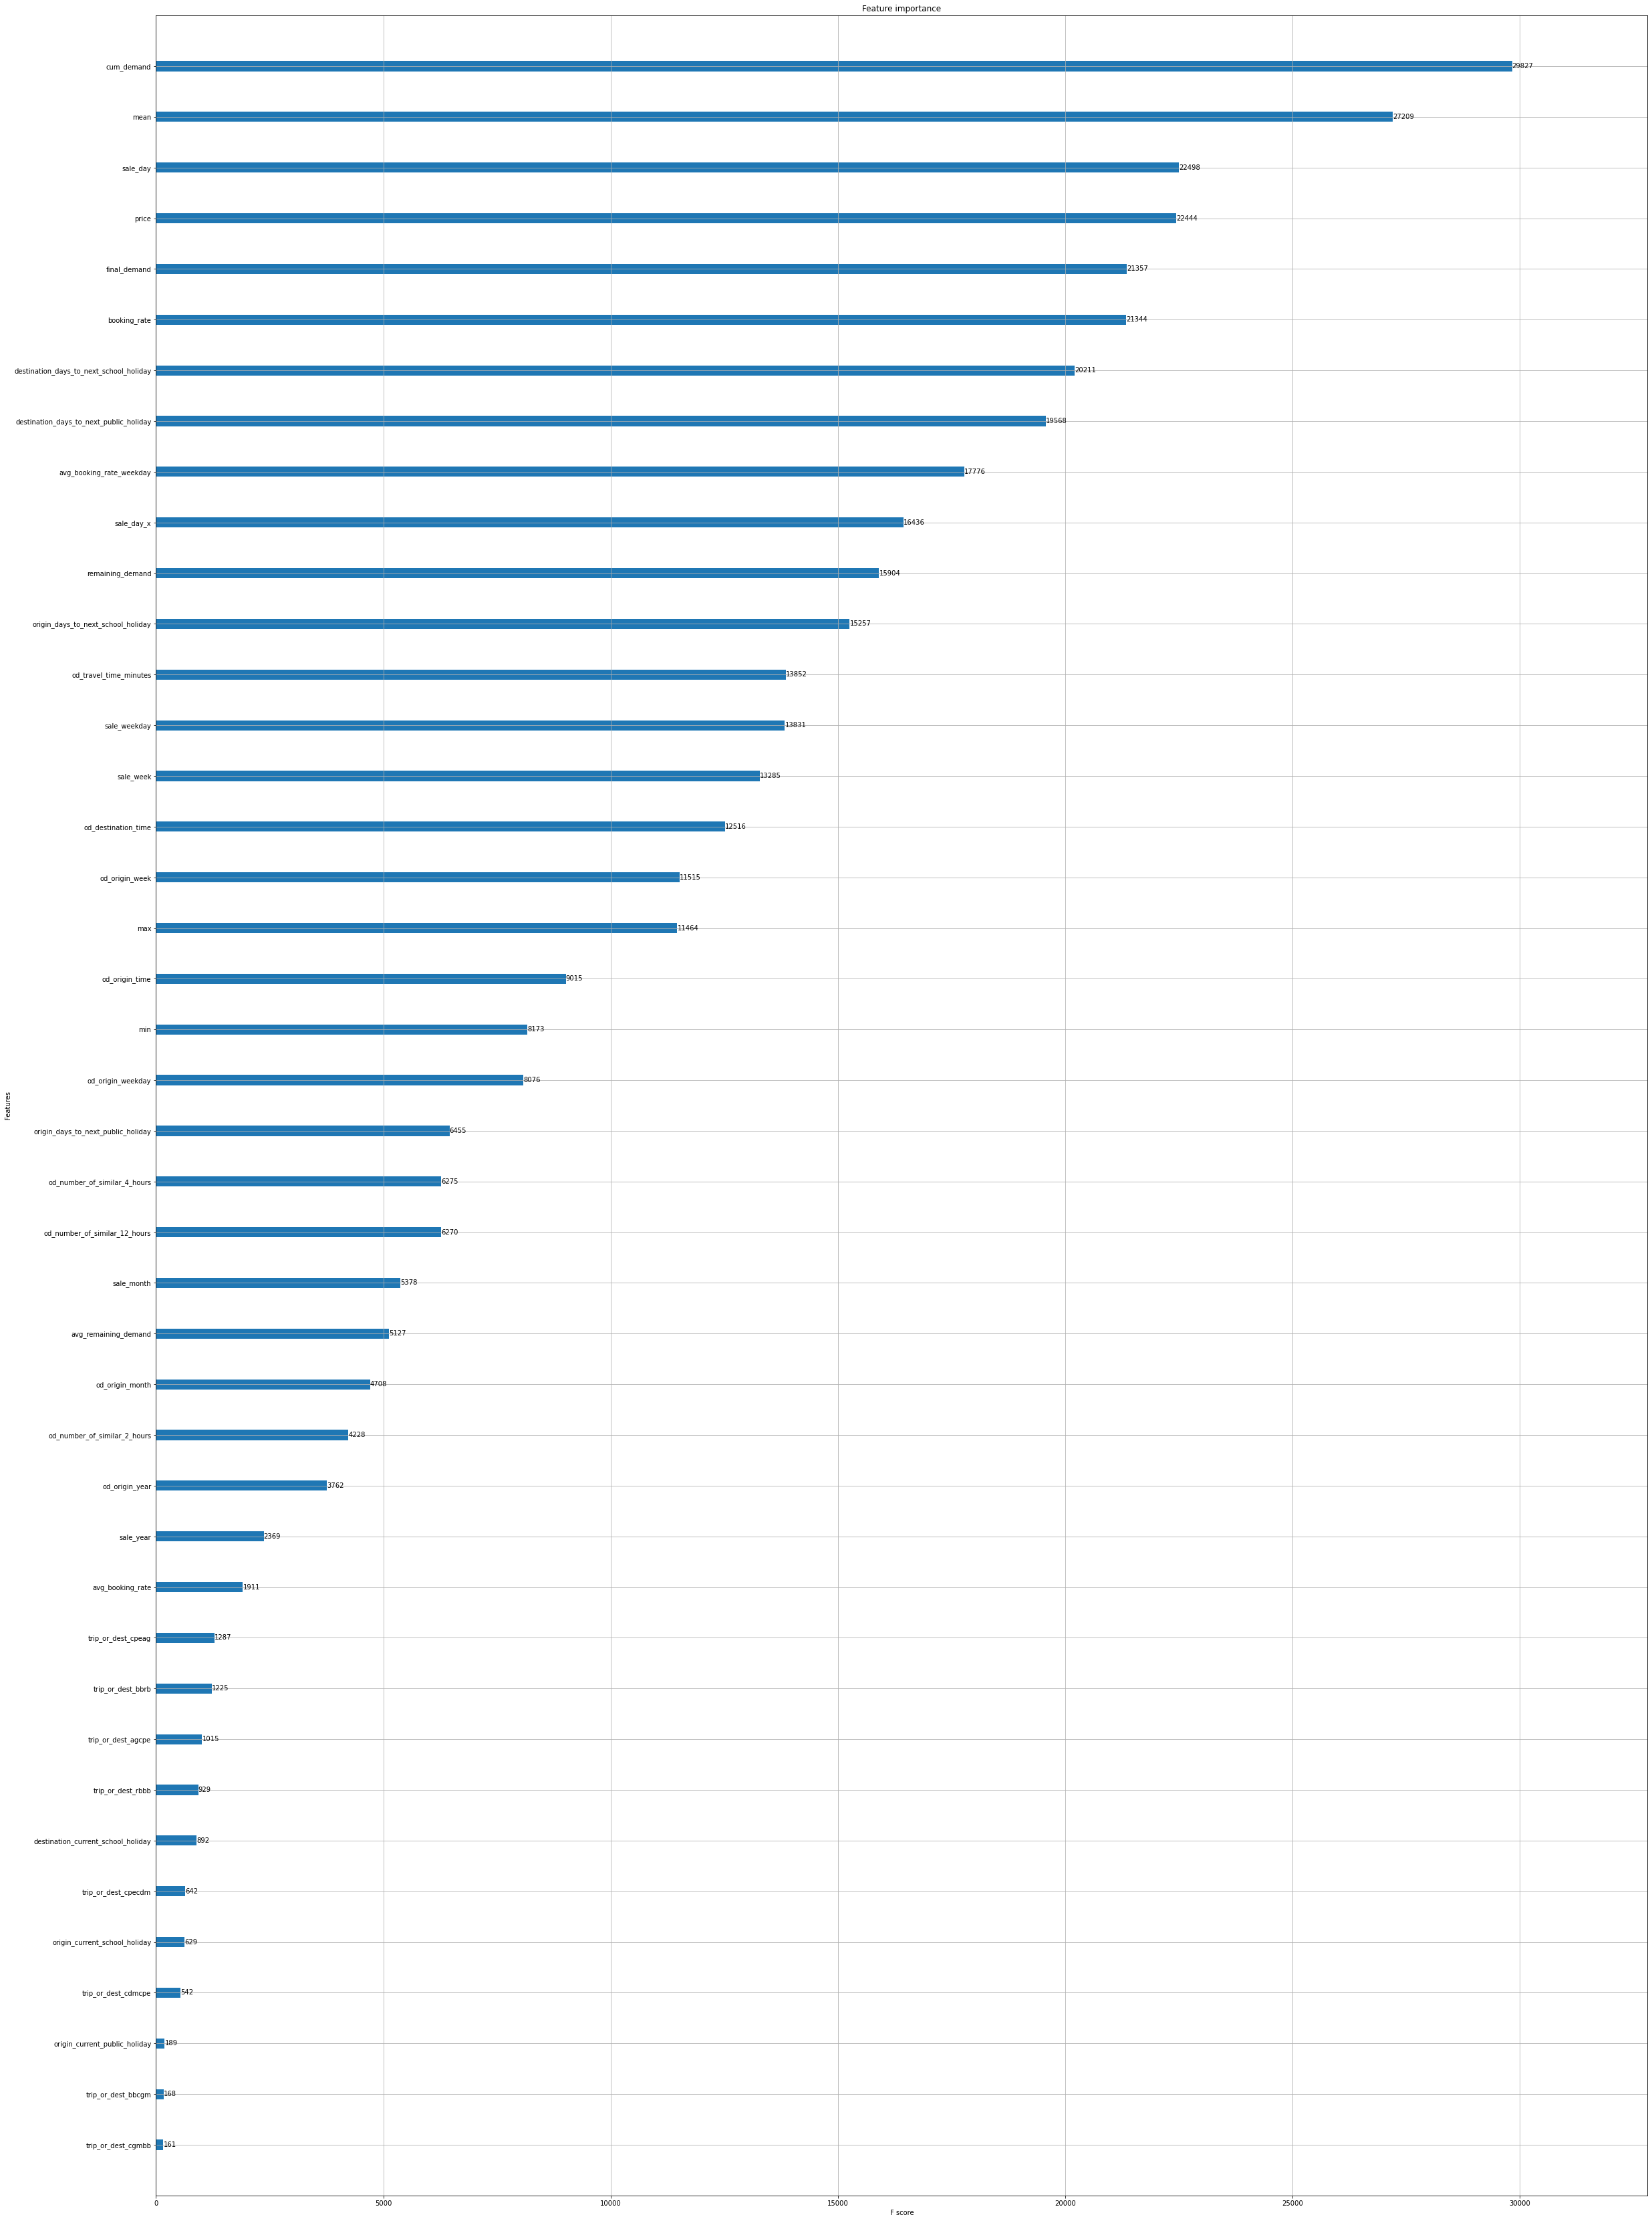

In [20]:
#plt.figure(figsize=(40,50))
fig, ax = plt.subplots(figsize=(40,60))
xgb.plot_importance(Xgb_model_trained, ax=ax)
plt.show()

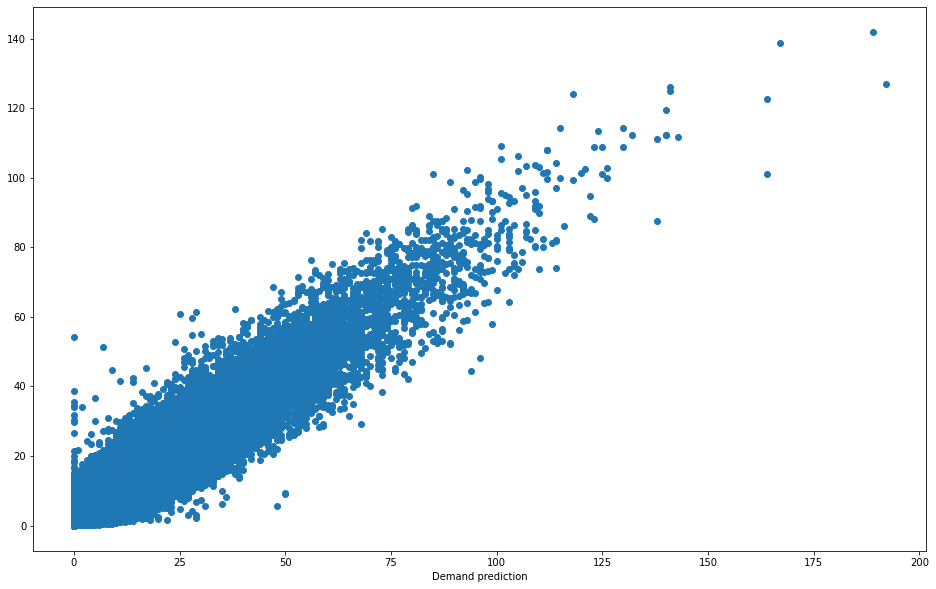

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(y_test,Xgb_model_trained.predict(X_test) )
plt.xlabel("Real demand")
plt.xlabel("Demand prediction")
plt.show()

### Validation du modèle

In [22]:
def pred_cumulative_demand_X(list_day_x, demand, X):
    
    somme = 0
    
    for v in range(len(list_day_x)-1, -1, -1):
        if list_day_x[v] >= X:
            somme += demand[v]        
        else:
            break
    return somme

def random_trip(data):
    
    trip_id = np.random.choice(data.trip_id.unique())
    
    
    return trip_id


def compute_pred_dem_cum(data, trip_id, model):
    remaining_demand_sale_x = {}
    res_trip_id = []
   
    trip_df = data.loc[(data['trip_id']==trip_id)]
    
    
    for sal_day_x, remaining_demand in zip(trip_df.sale_day_x, trip_df.remaining_demand):
        remaining_demand_sale_x[sal_day_x] = remaining_demand

    X_test,y_test = split_data(trip_df)
    days_val = [-90,-60,-30,-20,-15,-10,-7,-6,-5,-3,-2,-1]
    
    demand_prediction = model.predict(X_test)
    
    list_sale_day_x = list(X_test.sale_day_x)
    
    for d in days_val:
        res_trip_id.append(int(pred_cumulative_demand_X(list_sale_day_x,demand_prediction,d)))
        
    return res_trip_id, remaining_demand_sale_x



def compare_Y(remaining_demand_sale_x):
    days_vals = [-90,-60,-30,-20,-15,-10,-7,-6,-5,-3,-2,-1]
    y_test=[]
    for i in days_vals:
        if i in remaining_demand_sale_x:
            y_test.append(remaining_demand_sale_x[i])
        else:
            b=True
            while b:
                i+=1
                if i in remaining_demand_sale_x:
                    y_test.append(remaining_demand_sale_x[i])
                    b=False
                elif i==0:
                    y_test.append(0)
                    b=False
            
            
    return y_test

In [39]:
for _ in range(20):
    trip_id = random_trip(data_test_clean)
    remaining_demand_sale_x_from_prediction, remaining_demand_sale_x_true = compute_pred_dem_cum(data_test_clean, trip_id, Xgb_model_trained)
    remaining_demand_sale_x_true = compare_Y(remaining_demand_sale_x_true)
    mae_xgb = mean_absolute_error(remaining_demand_sale_x_from_prediction, remaining_demand_sale_x_true)
    print("remaining_demand_sale_x_from_prediction",remaining_demand_sale_x_from_prediction)
    print('remaining_demand_sale_x_true', remaining_demand_sale_x_true)
    print("MAE: ", mae_xgb)

remaining_demand_sale_x_from_prediction [442, 400, 334, 266, 233, 206, 178, 163, 149, 104, 73, 40]
remaining_demand_sale_x_true [387, 352, 291, 222, 189, 159, 146, 132, 118, 71, 40, 0]
MAE:  40.083333333333336
remaining_demand_sale_x_from_prediction [9, 9, 9, 9, 9, 8, 8, 7, 7, 5, 4, 3]
remaining_demand_sale_x_true [12, 12, 12, 11, 11, 11, 9, 9, 8, 6, 6, 0]
MAE:  2.1666666666666665
remaining_demand_sale_x_from_prediction [220, 202, 152, 95, 52, 21, 0, 0, 0, 0, 0, 0]
remaining_demand_sale_x_true [239, 223, 164, 104, 49, 21, 0, 0, 0, 0, 0, 0]
MAE:  5.333333333333333
remaining_demand_sale_x_from_prediction [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
remaining_demand_sale_x_true [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
MAE:  0.3333333333333333
remaining_demand_sale_x_from_prediction [10, 10, 10, 10, 9, 9, 8, 8, 8, 7, 7, 5]
remaining_demand_sale_x_true [12, 12, 12, 11, 11, 10, 10, 10, 10, 8, 6, 0]
MAE:  1.9166666666666667
remaining_demand_sale_x_from_prediction [10, 10, 10, 10, 10, 10, 9, 9, 8, 7, 5, 4

In [24]:
remaining_demand_sale_x_from_prediction, remaining_demand_sale_x_true = compute_pred_dem_cum(data_test_clean, trip_id, Xgb_model_trained)

In [25]:
remaining_demand_sale_x_from_prediction


[368, 345, 297, 255, 224, 180, 150, 131, 111, 57, 33, 0]

In [26]:
remaining_demand_sale_x_true = compare_Y(remaining_demand_sale_x_true)
print(remaining_demand_sale_x_true)

[345, 336, 287, 235, 206, 174, 139, 121, 94, 29, 0, 0]


In [27]:
mae_xgb = mean_absolute_error(remaining_demand_sale_x_from_prediction, remaining_demand_sale_x_true)
print("remaining_demand_sale_x_from_prediction",remaining_demand_sale_x_from_prediction)
print('remaining_demand_sale_x_true', remaining_demand_sale_x_true)
print("MAE: ", mae_xgb)

remaining_demand_sale_x_from_prediction [368, 345, 297, 255, 224, 180, 150, 131, 111, 57, 33, 0]
remaining_demand_sale_x_true [345, 336, 287, 235, 206, 174, 139, 121, 94, 29, 0, 0]
MAE:  15.416666666666666


In [122]:
all_mae=[]
for trip in trip_ids:
    y_pred, remaining_demand_sale_x = compute_pred_dem_cum(data_test, trip, xgb_model_grid_optim)
    y_test = compare_Y(remaining_demand_sale_x)
    all_mae.append( mean_absolute_error(y_pred, y_test))

In [123]:
all_mae

[3.8333333333333335,
 0.08333333333333333,
 54.0,
 51.416666666666664,
 0.25,
 99.5,
 76.25,
 4.166666666666667,
 62.25,
 0.6666666666666666,
 0.6666666666666666,
 59.083333333333336,
 67.5,
 25.333333333333332,
 42.583333333333336,
 30.666666666666668,
 52.166666666666664,
 0.25,
 17.5,
 34.75,
 0.5,
 57.25,
 0.0,
 40.5,
 1.8333333333333333,
 83.91666666666667,
 53.5,
 1.0,
 42.75,
 3.5833333333333335,
 81.58333333333333,
 107.91666666666667,
 40.666666666666664,
 2.3333333333333335,
 93.91666666666667,
 42.083333333333336,
 79.33333333333333,
 49.75,
 0.6666666666666666,
 0.0,
 1.1666666666666667,
 68.66666666666667,
 2.8333333333333335,
 5.916666666666667,
 1.0,
 54.0,
 2.0833333333333335,
 83.33333333333333,
 2.9166666666666665,
 0.0,
 0.5,
 96.16666666666667,
 82.25,
 0.0,
 23.5,
 67.58333333333333,
 125.5,
 3.6666666666666665,
 34.166666666666664,
 30.416666666666668,
 0.0,
 49.833333333333336,
 2.6666666666666665,
 82.25,
 73.58333333333333,
 5.083333333333333,
 0.08333333333333

In [124]:
np.mean(all_mae)

39.80916666666666

<BarContainer object of 100 artists>

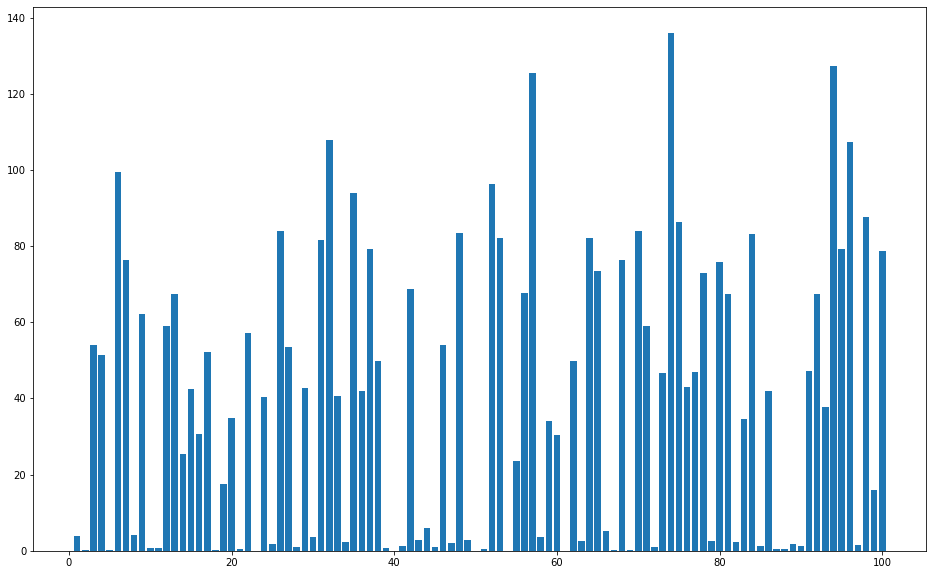

In [126]:
plt.figure(figsize=(16,10))
plt.bar( range(1,101),all_mae)

In [40]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.
